<a href="https://colab.research.google.com/github/vgilm/TAM/blob/main/PARCIAL_1_TAM_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

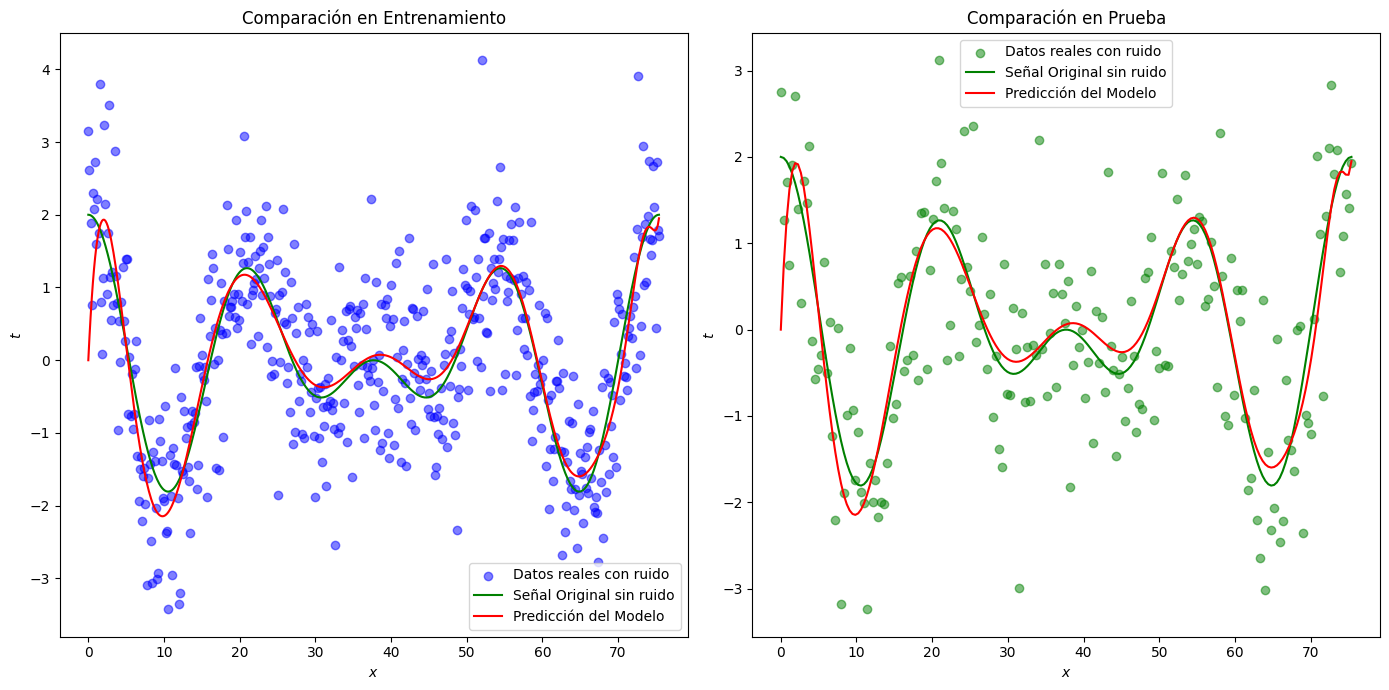

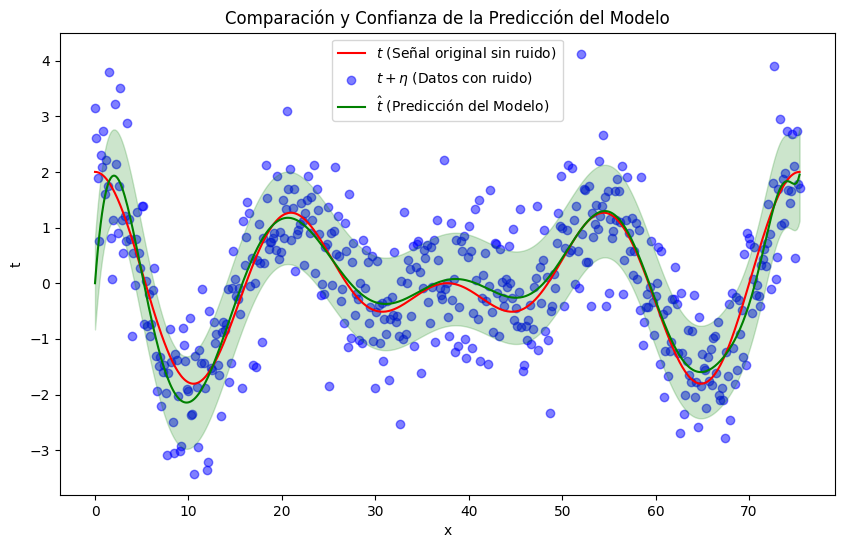

Varianza estimada del modelo: 0.6908750058812405


In [2]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
import matplotlib.pyplot as plt

def generate_data(x_range, n_samples, snr_db):
    """
    Genera la señal y la contamina con ruido blanco Gaussiano.

    Args:
        x_range (tuple): Tupla que contiene el rango de valores de x (inicio, fin).
        n_samples (int): Número de muestras a generar.
        snr_db (float): Relación señal a ruido en decibelios (dB).

    Returns:
        np.ndarray: Valores de x generados.
        np.ndarray: Señal generada con ruido.

    La señal se define como t_n = cos(x_n/3) + cos(x_n/4) + η_n, donde η_n representa
    el ruido blanco Gaussiano. Esta función primero genera una serie de valores x
    uniformemente espaciados dentro del rango especificado. Luego, calcula la señal
    sin ruido y añade el ruido basado en el SNR especificado.
    """
    # Generación de valores de x
    x = np.linspace(x_range[0], x_range[1], n_samples).reshape(-1, 1)
    # Señal sin ruido
    signal = np.cos(x / 3) + np.cos(x / 4)
    # Estimación de la varianza del ruido basada en el SNR en dB
    noise_variance = np.mean(signal**2) / (10**(snr_db / 10))
    # Generación y adición del ruido
    noise = np.random.normal(0, np.sqrt(noise_variance), size=signal.shape)
    return x, signal + noise

def polynomial_transform(x, degree):
    """
    Aplica un mapeo polinomial a los datos y los normaliza.

    Args:
        x (np.ndarray): Datos de entrada (valores de x).
        degree (int): Grado del polinomio para el mapeo.

    Returns:
        np.ndarray: Datos transformados y normalizados.

    Utiliza PolynomialFeatures de sklearn para generar un mapeo polinomial
    de los datos de entrada. Este mapeo incrementa la dimensionalidad de los
    datos, lo que permite modelar relaciones no lineales. Luego, se aplica
    MinMaxScaler para normalizar los datos transformados, lo cual es importante
    para la estabilidad numérica y la eficiencia del entrenamiento del modelo.
    """
    poly = PolynomialFeatures(degree=degree)
    phi = poly.fit_transform(x)
    scaler = MinMaxScaler()
    return scaler.fit_transform(phi)

def train_model(phi, t):
    """
    Entrena el modelo de regresión por máxima verosimilitud.

    Args:
        phi (np.ndarray): Datos de entrada transformados y normalizados.
        t (np.ndarray): Valores objetivo de la señal.

    Returns:
        np.ndarray: Pesos del modelo entrenado.
        float: Varianza estimada del ruido.

    El modelo de máxima verosimilitud se ajusta minimizando la diferencia
    cuadrática entre las predicciones y los valores reales de la señal.
    Esto se logra calculando los pesos óptimos w_ml que minimizan la
    función de costo. La varianza del ruido se estima como el promedio
    de los errores cuadráticos usando los pesos óptimos.
    """
    # Calculo de pesos utilizando la pseudo-inversa
    w_ml = np.linalg.pinv(phi.T @ phi) @ phi.T @ t
    # Estimación de la varianza del ruido
    sigma2_ml = np.mean((t - (phi @ w_ml))**2)
    return w_ml, sigma2_ml

def predict(phi, w):
    """
    Realiza predicciones utilizando el modelo entrenado.

    Args:
        phi (np.ndarray): Datos de entrada transformados y normalizados para predicción.
        w (np.ndarray): Pesos del modelo entrenado.

    Returns:
        np.ndarray: Predicciones del modelo.

    Calcula las predicciones del modelo para un nuevo conjunto de datos
    aplicando los pesos óptimos aprendidos durante el entrenamiento.
    """
    return phi @ w

# Parámetros de la simulación
x_range = (0, 24 * np.pi)
n_train = 500
n_test = 200
Q = 29# Grado del polinomio
SNRdB = 2  # SNR en decibelios

# Generación de datos de entrenamiento y prueba
x_train, t_train = generate_data(x_range, n_train, SNRdB)
x_test, t_test = generate_data(x_range, n_test, SNRdB)

# Transformación y normalización de los datos
phi_train = polynomial_transform(x_train, Q)
phi_test = polynomial_transform(x_test, Q)

# Entrenamiento del modelo
w_ml, sigma2_ml = train_model(phi_train, t_train)

# Predicción en el conjunto de prueba
t_pred_test = predict(phi_test, w_ml)

# Visualización de resultados
# Importación de bibliotecas necesarias
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
import matplotlib.pyplot as plt

# Funciones previamente definidas: generate_data, polynomial_transform, train_model, predict

# Generación de datos de entrenamiento y prueba
x_train, t_train = generate_data(x_range, n_train, SNRdB)
x_test, t_test = generate_data(x_range, n_test, SNRdB)

# Generación de la señal original sin ruido para comparación
_, signal_original_train = generate_data(x_range, n_train, 100)  # SNR alto simula "sin ruido"
_, signal_original_test = generate_data(x_range, n_test, 100)  # SNR alto simula "sin ruido"

# Transformación y normalización de los datos
phi_train = polynomial_transform(x_train, Q)
phi_test = polynomial_transform(x_test, Q)

# Entrenamiento del modelo y predicción en el conjunto de prueba
w_ml, sigma2_ml = train_model(phi_train, t_train)
t_pred_train = predict(phi_train, w_ml)
t_pred_test = predict(phi_test, w_ml)

def visualize_results_with_original(x_train, signal_original_train, t_train, t_pred_train, x_test, signal_original_test, t_test, t_pred_test):
    """
    Visualiza los resultados del entrenamiento y la prueba, incluyendo la comparación
    con la señal original sin ruido.
    """
    plt.figure(figsize=(14, 7))

    # Entrenamiento
    plt.subplot(1, 2, 1)
    plt.scatter(x_train, t_train, color='blue', alpha=0.5, label='Datos reales con ruido')
    plt.plot(x_train, signal_original_train, 'g-', label='Señal Original sin ruido')
    plt.plot(x_train, t_pred_train, 'r-', label='Predicción del Modelo')
    plt.title('Comparación en Entrenamiento')
    plt.xlabel('$x$')
    plt.ylabel('$t$')
    plt.legend()

    # Prueba
    plt.subplot(1, 2, 2)
    plt.scatter(x_test, t_test, color='green', alpha=0.5, label='Datos reales con ruido')
    plt.plot(x_test, signal_original_test, 'g-', label='Señal Original sin ruido')
    plt.plot(x_test, t_pred_test, 'r-', label='Predicción del Modelo')
    plt.title('Comparación en Prueba')
    plt.xlabel('$x$')
    plt.ylabel('$t$')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Llamada a la función de visualización modificada
visualize_results_with_original(x_train, signal_original_train, t_train, t_pred_train, x_test, signal_original_test, t_test, t_pred_test)

# Calculamos la varianza del modelo basada en el conjunto de entrenamiento
var_ml = (np.linalg.norm(t_train - t_pred_train)**2) / len(t_train)

plt.figure(figsize=(10, 6))
# Graficar la señal original sin ruido
plt.plot(x_train, signal_original_train, 'r-', label='$t$ (Señal original sin ruido)')
# Graficar los datos de entrenamiento con ruido
plt.scatter(x_train, t_train, color='b', alpha=0.5, label='$t + \eta$ (Datos con ruido)')
# Graficar las predicciones del modelo para el conjunto de entrenamiento
plt.plot(x_train, t_pred_train, 'g-', label='$\hat{t}$ (Predicción del Modelo)')
# Añadir banda de confianza basada en la varianza estimada del modelo
plt.fill_between(x_train.ravel(), t_pred_train.ravel() - np.sqrt(var_ml)*np.ones(len(t_pred_train)),
                 t_pred_train.ravel() + np.sqrt(var_ml)*np.ones(len(t_pred_train)), color='green', alpha=0.2)

plt.legend()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Comparación y Confianza de la Predicción del Modelo')
plt.show()

print(f"Varianza estimada del modelo: {var_ml}")







##MAX A POSTERIORI

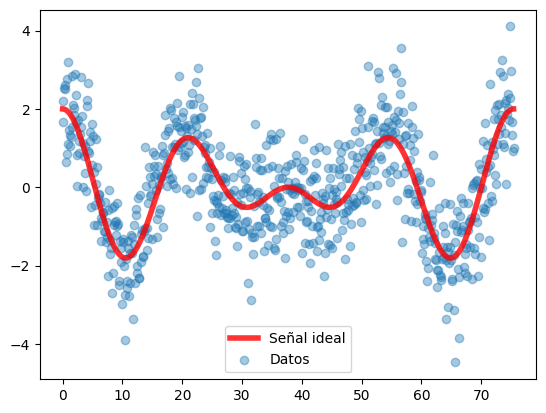

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#gerando los datos de entrada de la función dada
N = 700 #Datos totales
SNRdB = 2 # Relación señal-ruido en dB
x_n = np.linspace(0,24*np.pi,N)#generando datos
tn_pura = np.cos(x_n/3)+np.cos(x_n/4) #señal verdadera
#Calcular la potencia de la señal verdadera:
P_signal = np.mean(tn_pura**2)

# Calcular la potencia del ruido (considerando SNR)
P_noise = P_signal / (10**(SNRdB / 10))

# Generar ruido blanco gaussiano
eta = np.random.normal(0, np.sqrt(P_noise), len(x_n))

#Señal pura + ruido
t_nr= tn_pura + eta

#graficamos la señal dada + la ruidosa

plt.plot(x_n,tn_pura,label='Señal ideal',c='r',linewidth=4, alpha=0.8)
plt.scatter(x_n,t_nr, alpha=0.4, label="Datos")
plt.legend()
plt.show()
#Graficamos la señal ideal y los datos:

In [ ]:
# Dividir los datos en conjuntos de entrenamiento y prueba utilizando train_test_split.

X_train, X_test, t_train, t_test = train_test_split(x_n.reshape(-1,1), t_nr.reshape(-1,1),test_size=200/N, random_state=42)

print(X_train.shape,X_test.shape,t_train.shape,t_test.shape)

(500, 1) (200, 1) (500, 1) (200, 1)


Para el entrenamiento y realizar el mapeo $ \phi(\cdot)$ del tipo polinomial de orden $Q$ se utilizó la libreria sklearn para facilitar la generación de las características.

In [ ]:
# Mapeo de Representación polinomial desde la libreria sklearn, para entrenamiento

# Definir el grado del polinomio
Q = 25

# Crear un objeto PolynomialFeatures para generar características polinomiales hasta el grado especificado
phiQ = PolynomialFeatures(degree=Q)

# Representar los datos de entrenamiento como un polinomio de grado Q
Phi = phiQ.fit_transform(X_train)

# Escalar los datos utilizando MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(Phi)
Phi = scaler.transform(Phi)

# Asegurar que la primera columna de Phi sea 1 para el término de sesgo del modelo
Phi[:, 0] = 1  # Como da una columna de 0, se cambia por columna de 1 para poder calcular la inversa y preservar la estabilidad computacional


Por Max a posteriori Obtenidos los pesos en el punto 2.1, se tiene que para MAP :

$W_{MAP}=t_{n}^{T} \phi\left (  \phi ^{T}\phi+\lambda I \right )^{-1}$ siendo :
$\lambda= \frac{\sigma ^{2}_{\eta }}{\sigma ^{2}_{\omega}}$

In [ ]:
Lambda= 2 #Priori dado por la varianza del ruido y de los pesos.

In [ ]:
W_map= t_train.T@Phi@(np.linalg.inv(Phi.T@Phi+Lambda)) #Pesos de MAP

In [ ]:
def max_apos(X, W):
    """
    Calcula la predicción utilizando el modelo de regresión lineal
    con la máxima a posteriori (MAP).

    Parámetros:
        - X: Conjunto de datos de entrada.
        - W: Parámetros del modelo de regresión (pesos).

    Retorna:
        - y: Predicción del modelo para el conjunto de datos X.
    """

    # Determinar el grado del polinomio utilizado en el modelo
    Q = W.shape[1] - 1

    # Representar los datos de entrada como un polinomio de grado Q
    phiQ = PolynomialFeatures(degree=Q)
    Phi = phiQ.fit_transform(X)

    # Normalizar los datos utilizando el mismo escalador que se utilizó durante el entrenamiento
    Phi = scaler.transform(Phi)

    # Agregar una columna de unos al principio de la matriz Phi
    # Esto es necesario para calcular el término de sesgo del modelo
    Phi[:, 0] = 1

    # Calcular la predicción utilizando los parámetros del modelo
    y = Phi @ W.T

    return y


In [ ]:
t_predictMAP= max_apos( X_test,W_map) #predicción de MAP

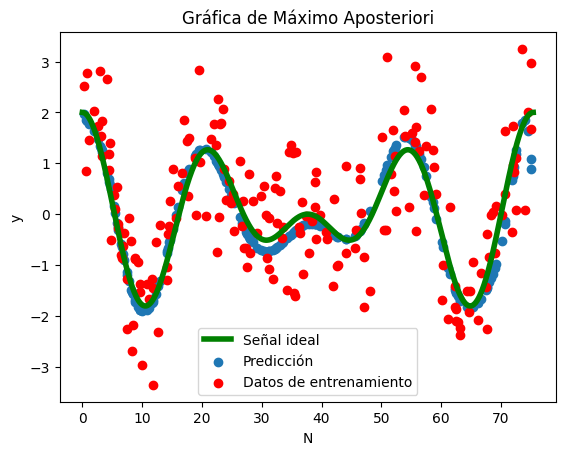

In [ ]:

# Graficar la señal verdadera (valores reales)
plt.plot(x_n, tn_pura, label="Señal ideal", color="green", linewidth=4)

# Graficar la predicción del modelo bayesiano
plt.scatter(X_test, t_predictMAP, label="Predicción")

# Graficar los datos de entrenamiento
plt.scatter(X_test, t_test, color="r", label="Datos de entrenamiento")

# Agregar etiquetas y leyenda
plt.xlabel('N')
plt.ylabel('y')
plt.title('Gráfica de Máximo Aposteriori')
plt.legend()

# Mostrar la gráfica
plt.show()